### Agent-Lab: Coordinator -> Planner -> Supervisor Agent

Objective of this notebook is evaluating and adapting a [Multi-Agent Supervisor Architecture](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) with coordinator and execution planning steps.

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    DEVELOPING="True"
    OLLAMA_ENDPOINT="http://localhost:11434"
    TAVILY_API_KEY="???"
    XAI_API_KEY="???"
    ```

---

In [1]:
%%capture

import os

os.chdir("..")

from dotenv import load_dotenv

load_dotenv()

from IPython.display import Image, Markdown, display

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# graph rendering
import nest_asyncio
nest_asyncio.apply()

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
# agent = experiment_utils.create_ollama_agent(
#     agent_type="coordinator_planner_supervisor",
#     llm_tag="granite3.2:latest",
#     ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
# )

# vision model is required by browser-lab (uses vision to parse the rendered page)
agent = experiment_utils.create_xai_agent(
    agent_type="coordinator_planner_supervisor",
    llm_tag="grok-2-vision",
    api_key=os.getenv("XAI_API_KEY"),
)

# updated_agent = experiment_utils.update_agent_setting(
#     agent_id=agent["id"],
#     setting_key="deep_search_mode",
#     setting_value="True"
# )

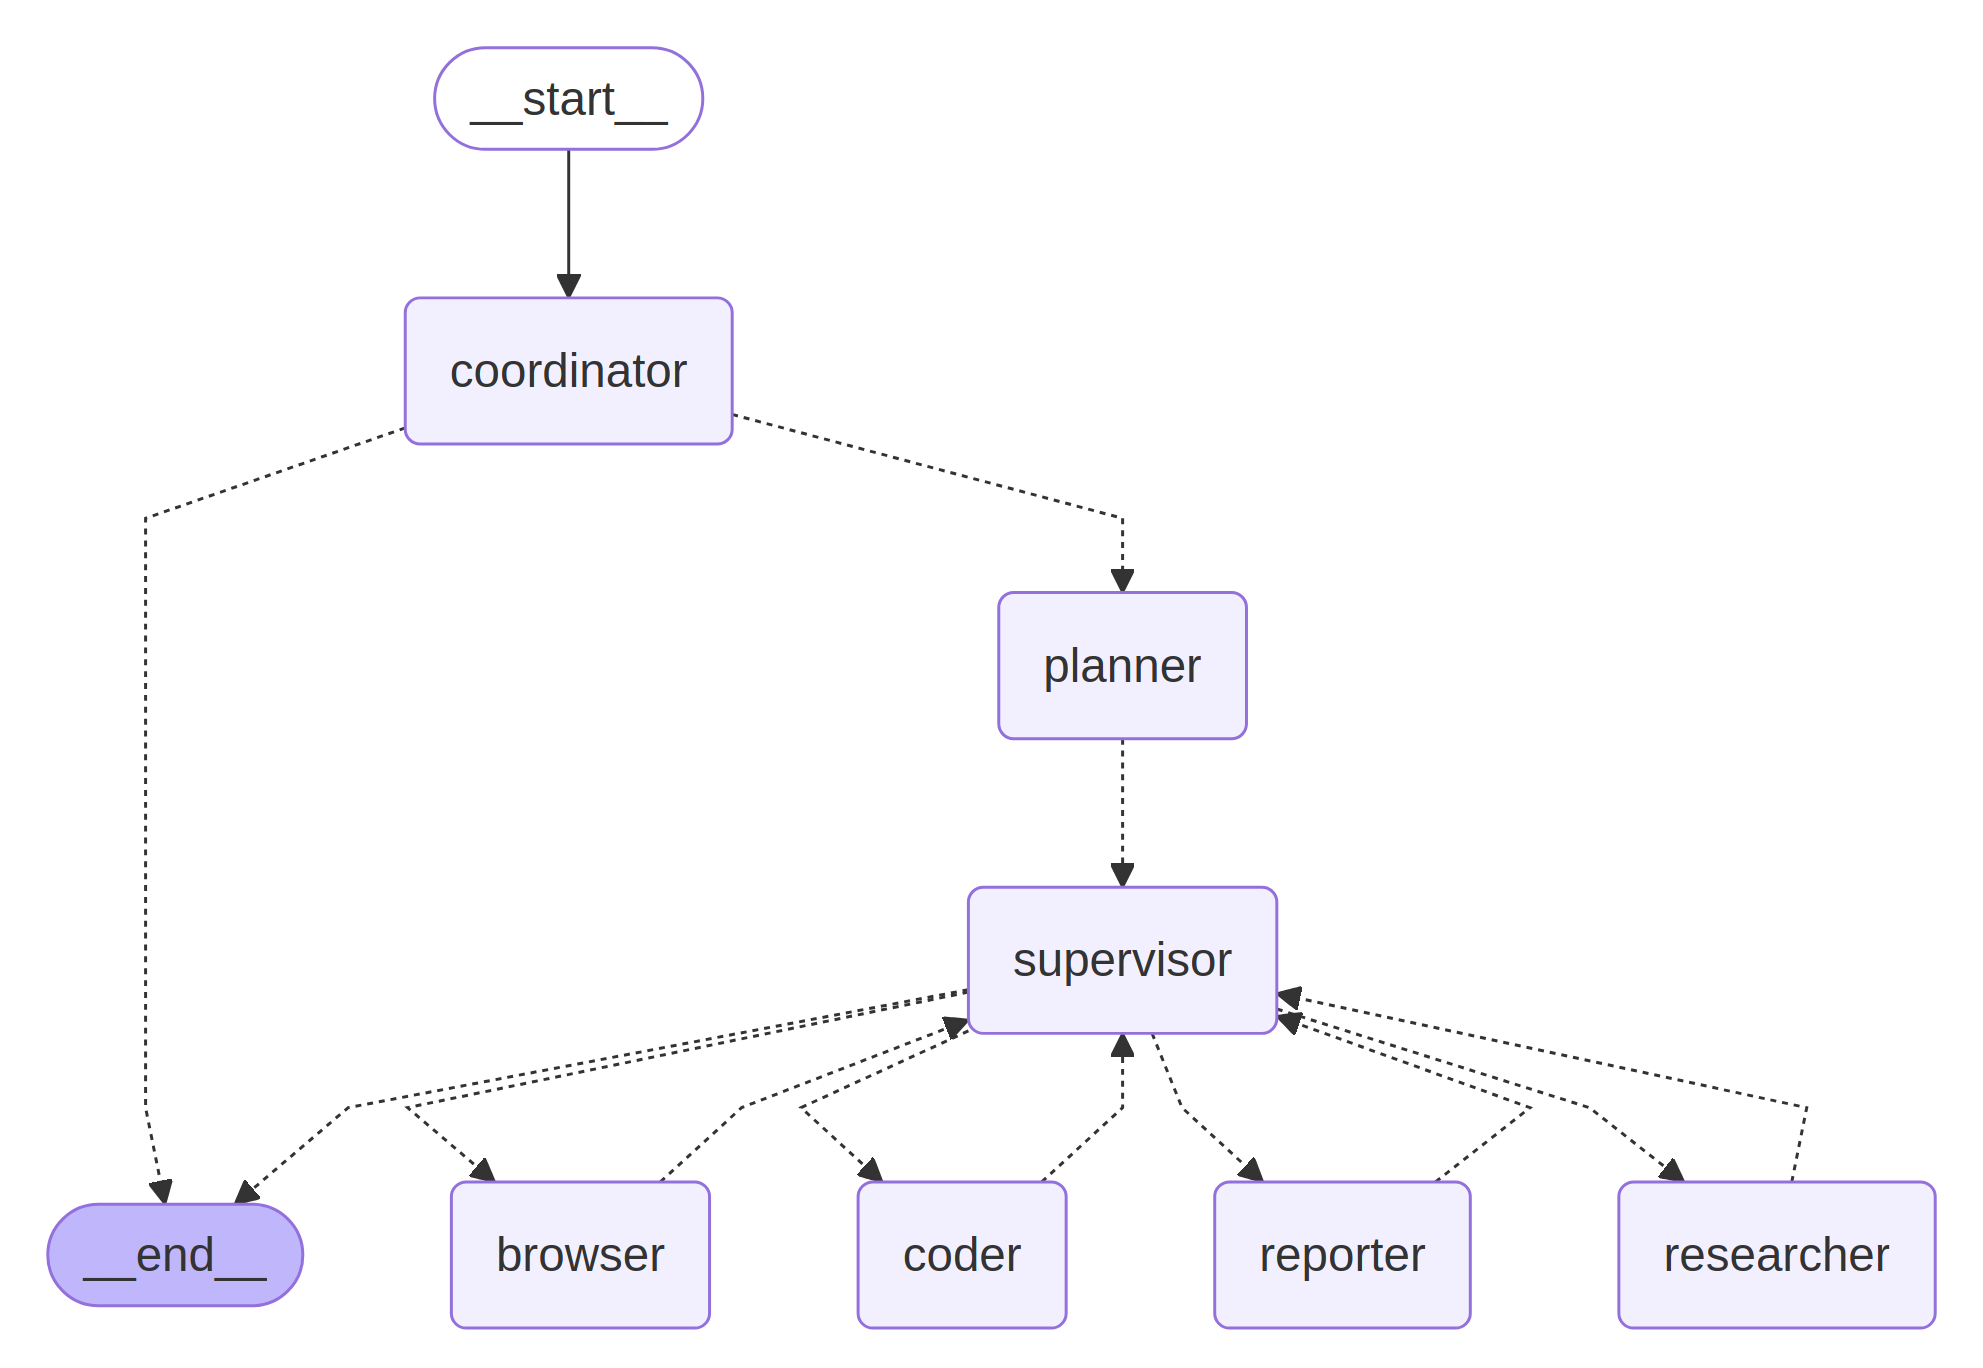

In [3]:
# get agent instance
coordinator_planner_supervisor_agent = container.coordinator_planner_supervisor_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# get config
agent_config = coordinator_planner_supervisor_agent.get_config(agent["id"])

# Create Graph
workflow_builder = coordinator_planner_supervisor_agent.get_workflow_builder(
    agent["id"]
)
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

### Evaluate Researcher

In [4]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="What characterizes a good general according to Sun Tzu?",
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

In [5]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Report: Characteristics of a Good General According to Sun Tzu

## Executive Summary

This report examines the characteristics of a good general as outlined by Sun Tzu in his seminal work, 'The Art of War'. Sun Tzu's philosophy emphasizes a balance of civil virtues and martial prowess, strict discipline, strategic use of terrain, and exceptional abilities in planning and estimation.

## Key Findings

- **Civil Virtues and Martial Prowess**: A good general must possess civil virtues to gain the loyalty of the people and martial prowess to intimidate enemies.
- **Discipline**: Effective command and habitual enforcement of orders lead to a well-disciplined army.
- **Strategic Use of Terrain**: The natural landscape is an ally, but the general's ability to adapt to and utilize it is crucial.
- **Strategic Estimation**: The ability to estimate the enemy, control victory, and calculate logistical challenges is the hallmark of a great general.

## Detailed Analysis

### Civil Virtues and Martial Prowess

Sun Tzu, through the reference to Ssu-ma Jang-chu, suggests that a general must be loved by his people for his civil virtues while simultaneously being feared by his enemies for his martial abilities. This dual nature ensures loyalty from within and respect from without.

### Discipline

According to Sun Tzu, discipline within the army is not inherent but cultivated through the consistent enforcement of commands. A disciplined army is a direct result of a general's strict adherence to this principle.

### Strategic Use of Terrain

While terrain offers natural advantages, Sun Tzu notes that a general's prowess lies in leveraging these advantages. Ch'en Hao's comment highlights that while weather and seasons are important, terrain provides more consistent strategic benefits.

### Strategic Estimation

The core of a great general's skill is in his strategic acumen. Sun Tzu states that understanding the enemy, managing victory, and calculating logistical challenges are what distinguish a good general from a great one. This involves deep planning, rapid decision-making, and a clear vision.

## Conclusions and Recommendations

**Conclusions**: A good general according to Sun Tzu must:

- Balance civil engagement with martial strength.
- Ensure strict discipline through habitual command enforcement.
- Utilize terrain strategically.
- Excel in strategic planning, enemy estimation, and logistical foresight.

**Recommendations**: For those studying military leadership or aiming to apply Sun Tzu's principles in modern contexts:

- Develop a leadership style that combines empathy with assertiveness.
- Implement rigorous training regimes to foster discipline.
- Study and understand the impact of geography on strategy.
- Enhance skills in strategic analysis, particularly in scenario planning and risk assessment.

**Source**: All information provided is derived from Sun Tzu's 'The Art of War', specifically from the quotes and commentary included in the knowledge base research.

**Note**: The data provided was comprehensive for the analysis, and no additional information was required.

---
### Evaluate Coder

In [6]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="With coder, generate a simple hello world in Python.",
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

In [7]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Report: Simple Hello World in Python

## Executive Summary

This report documents the process of generating and executing a simple 'Hello World' program in Python, as requested. The task was straightforward and involved writing a single line of Python code to print the greeting to the console.

## Methodology

### Step-by-Step Process:

1. **Analyze Requirements**: The task was to create a simple Python script that prints "Hello, World!" to the console.

2. **Plan the Solution**: Since the requirement is basic, the solution was planned to use Python directly for output.

3. **Implement the Solution**:
   - Python was chosen as it's the language specified in the request.
   - The code `print('Hello, World!')` was implemented to meet the requirement.

```python
print('Hello, World!')
```

4. **Test the Solution**: The code was executed to verify that it prints the expected output.

5. **Document the Methodology**: This section outlines the approach taken, focusing on the simplicity and directness of the task.

6. **Present Results**: The output of the script is shown below.

### Output:

```
Hello, World!
```

## Conclusion

The task was successfully completed with the Python code printing "Hello, World!" to the console. This simple exercise serves as a fundamental example of how to use Python for basic output operations, demonstrating the ease of use of Python for beginners or as a quick test of Python environment setup.

#### Evaluate coder memory (convert function to other language)

In [8]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="Please convert this python code to bash.",
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

In [9]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Report: Conversion of Python 'Hello World' to Bash Script

## Executive Summary

This report details the process of converting a simple Python 'Hello World' script to an equivalent Bash script. The task was to translate Python's `print` function into a Bash command that produces the same output.

## Methodology

### Step-by-Step Process:

1. **Analyze Requirements**: The task required converting the Python code `print('Hello, World!')` to a Bash script.

2. **Plan the Solution**: Since Bash uses `echo` for printing text to the console, this was identified as the direct equivalent to Python's `print`.

3. **Implement the Solution**:
   - Bash was chosen because the task specified conversion to Bash.
   - The Bash command `echo 'Hello, World!'` was implemented to achieve the same output as the Python script.

```bash
echo 'Hello, World!'
```

4. **Test the Solution**: The Bash command was executed to ensure it prints "Hello, World!" to the console.

5. **Document the Methodology**: This section explains the straightforward conversion process from Python to Bash.

6. **Present Results**: The output of the Bash command is shown below.

### Output:

```
Hello, World!
```

## Conclusion

The conversion was successfully executed with the Bash command `echo 'Hello, World!'` producing the expected output. This task illustrates the basic difference in syntax between Python and Bash for simple output operations, highlighting the use of `echo` in Bash for what `print` does in Python.

---
### Evaluate Browser

In [10]:
# %%capture
message = MessageRequest(
    message_role="human",
    message_content=(
        "With the browser, go to https://en.wikipedia.org/wiki/Mathematical_finance and summarize the article."
    ),
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

**Browser Navigation:**

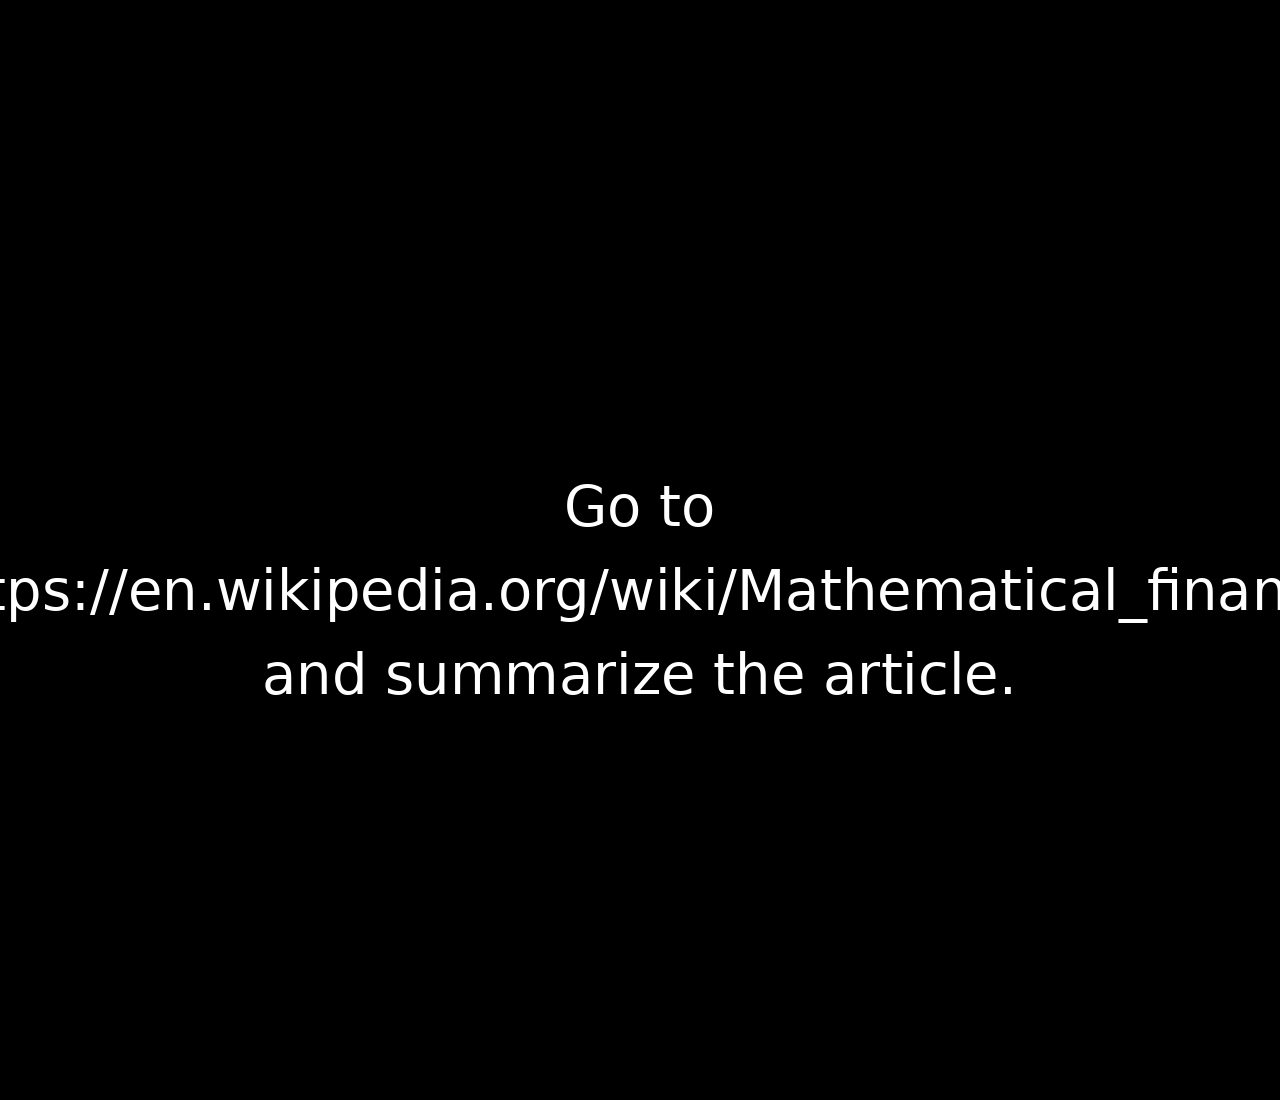

In [13]:
display(Markdown("**Browser Navigation:**"))
display(Image(filename="notebooks/coordinator_planner_supervisor_agent.gif"))

In [12]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Report: Overview of Mathematical Finance

## Executive Summary

This report provides an overview of Mathematical Finance, based on general knowledge due to an issue with direct summarization from the Wikipedia page on the subject. Mathematical finance is a discipline that employs mathematical models and theories to analyze and manage financial markets.

## Key Findings

- **Option Pricing**: Utilizes models like the Black-Scholes to calculate the theoretical value of options.
- **Risk Management**: Employs statistical methods to assess and mitigate financial risks.
- **Portfolio Optimization**: Involves strategies like the Markowitz model to optimize investment portfolios for risk and return.
- **Stochastic Processes**: Uses random processes to model financial market behavior and predict future trends.

## Detailed Analysis

### Option Pricing

Mathematical finance is crucial in the pricing of financial derivatives, particularly options. The Black-Scholes model is a fundamental tool in this area, providing a framework to estimate the price of options over time, considering factors like the underlying asset's price, time to expiration, volatility, and risk-free rate.

### Risk Management

This field applies mathematical techniques to quantify the risk associated with financial instruments. Techniques include Value at Risk (VaR), stress testing, and the use of derivatives for hedging purposes.

### Portfolio Optimization

Harry Markowitz's Modern Portfolio Theory is a cornerstone here, where the goal is to construct portfolios that offer the highest expected return for a given level of risk, or the lowest risk for a given level of expected return. This involves solving optimization problems with constraints related to asset allocation.

### Stochastic Processes

Financial markets are modeled using stochastic calculus, where processes like Geometric Brownian Motion are used to simulate price paths of assets. This helps in forecasting future prices and understanding the dynamics of market movements under uncertainty.

## Conclusions and Recommendations

**Conclusions**: Mathematical finance integrates advanced mathematics into financial decision-making, enhancing the precision in pricing, managing risk, and optimizing investments. The field is pivotal for modern financial engineering and quantitative analysis.

**Recommendations**:

- For those interested in a deeper understanding, direct reading of the Wikipedia article or specialized texts on mathematical finance is recommended.
- Practitioners in finance should consider incorporating mathematical finance techniques for more robust financial strategies.
- Educational institutions should continue to emphasize the importance of mathematical finance in their curricula, given its growing relevance in the financial sector.

**Source**: The information provided is based on general knowledge of Mathematical Finance. Due to technical issues, the specific content from the Wikipedia article could not be summarized directly. For precise details, visiting the Wikipedia page or consulting specialized literature is advised. 

**Note**: The data for direct summarization was not available due to an issue with the browser tool. If further details are required, manual reading or alternative methods should be employed.